In [1]:
# 모든 데이터를 합치는 코드
import pandas as pd

# 파일 경로 목록과 대응 열 이름 매핑
file_paths = {
    '2015': '2015.csv',
    '2016': '2016.csv',
    '2017': '2017.csv',
    '2018': '2018.csv',
    '2019': '2019.csv',
    '2020': '2020.csv',
    '2021': '2021.csv',
    '2022': '2022.csv',
    '2023': '2023.csv'
}

# 이름이 다른 행의 이름 통일을 위한 매핑
column_mappings = {
    '2015': {'Country': 'Country', 'Happiness Rank': 'Happiness Rank', 'Happiness Score': 'Happiness Score'},
    '2016': {'Country': 'Country', 'Happiness Rank': 'Happiness Rank', 'Happiness Score': 'Happiness Score'},
    '2017': {'Country': 'Country', 'Happiness Rank': 'Happiness.Rank', 'Happiness Score': 'Happiness.Score'},
    '2018': {'Country': 'Country or region', 'Happiness Rank': 'Overall rank', 'Happiness Score': 'Score'},
    '2019': {'Country': 'Country or region', 'Happiness Rank': 'Overall rank', 'Happiness Score': 'Score'},
    '2020': {'Country': 'Country name', 'Happiness Rank': 'Ladder score', 'Happiness Score': 'Ladder score'},
    '2021': {'Country': 'Country name', 'Happiness Rank': 'Ladder score', 'Happiness Score': 'Ladder score'},
    '2022': {'Country': 'Country', 'Happiness Rank': 'RANK', 'Happiness Score': 'Happiness score'},
    '2023': {'Country': 'Country name', 'Happiness Rank': 'Ladder score', 'Happiness Score': 'Ladder score'}
}

# 통일된 열 이름
standard_columns = ['Country', 'Happiness Rank', 'Happiness Score', 'Year']

# 결과를 저장할 리스트
file_df = []

# 파일 처리
for year, file_path in file_paths.items():
    try:
        # 데이터 읽기
        df = pd.read_csv(file_path)
        
        # 열 이름 매핑 및 데이터 필터링
        mappings = column_mappings[year]
        df_filtered = df.rename(columns=mappings)[list(mappings.values())]
        df_filtered.columns = ['Country', 'Happiness Rank', 'Happiness Score']  # 열 이름 통일
        df_filtered['Year'] = year  # 연도 추가
        file_df.append(df_filtered)
    except Exception as e:
        print(f"에러 {file_path} ({year}): {e}")

# 데이터 결합
mix_df = pd.concat(file_df, ignore_index=True)

# 결과 저장
mix_df.to_csv('all.csv', index=False)

print("성공")


성공


In [2]:
# 랭크가 없는 데이터가있어서 점수를 기준으로 랭크를 주는 코드
import pandas as pd

# 랭크가 없는 연도를 처리하고 랭크를 추가하는 함수
def add_rank(allgps, year_column='Year', score_column='Happiness Score', rank_column='Happiness Rank', years=[2020, 2021, 2023]):
    for year in years:
        # 특정 연도의 데이터를 필터링
        year_allgps = allgps[allgps[year_column] == year]
        
        # 점수를 기준으로 내림차순 정렬하고 순위를 할당
        year_allgps = year_allgps.sort_values(by=score_column, ascending=False)
        year_allgps[rank_column] = range(1, len(year_allgps) + 1) 
        
        # 원래 데이터프레임에 정렬된 데이터와 순위를 업데이트
        allgps.loc[year_allgps.index, rank_column] = year_allgps[rank_column]
    
    return allgps

# 데이터셋 로드
file_path = 'all.csv'
allgps = pd.read_csv(file_path)

# 랭크 업데이트 함수를 적용
up_allgps = add_rank(allgps)

# 업데이트된 데이터셋 저장
updated_file_path = 'all_rank.csv'
up_allgps.to_csv(updated_file_path, index=False)

print("성공")


성공


In [3]:
# 기존 합친코드와 gdp코드를 합치는 코드
all_rank = pd.read_csv('all_rank.csv')
gdp_allgps = pd.read_csv('API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2.csv', skiprows=4) # 쓸데없는 위에 4줄 스킵 

# GDP 데이터에서 필요한 열만 추출
gdp_allgps = gdp_allgps[['Country Name', 'Country Code', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']]

# 행복도 데이터에서 나라 이름의 공백을 제거하여 정렬합니다.
# 'Country' 열이 GDP 데이터의 'Country Name'과 일치한다고 가정합니다.
all_rank['Country'] = all_rank['Country'].str.strip()

# 행복도 데이터와 GDP 데이터를 국가 이름을 기준으로 병합합니다.
merged_allgps = pd.merge(
    all_rank,  # 행복도 데이터
    gdp_allgps,        # GDP 데이터
    left_on='Country',       # 행복도 데이터의 'Country' 열
    right_on='Country Name', # GDP 데이터의 'Country Name' 열
    how='left'               # 왼쪽 데이터(행복도 데이터)를 기준으로 병합
)

# 행복도 데이터의 'Year' 열을 기준으로 해당 연도의 GDP 값을 가져오는 함수 정의
def get_gdp_for_year(row):
    year = str(row['Year'])  # 'Year' 열의 값을 문자열로 변환
    if year in gdp_allgps.columns:  # GDP 데이터의 열에 해당 연도가 있는지 확인
        return row[year]          # 해당 연도의 GDP 값을 반환
    return None                   # 없으면 None 반환

# 'GDP'라는 새로운 열을 추가하여 각 행의 연도에 맞는 GDP 값을 삽입합니다.
merged_allgps['GDP'] = merged_allgps.apply(get_gdp_for_year, axis=1)

# 불필요한 연도 열은 삭제하여 출력 데이터를 간소화합니다.
merged_allgps = merged_allgps.drop(columns=[str(year) for year in range(2015, 2024) if str(year) in merged_allgps.columns])

merged_allgps.to_csv('allfnl.csv')


In [4]:
#gdp 행에 공백값은 제거하는 코드
import pandas as pd

file_path = 'allfnl.csv'
df = pd.read_csv(file_path)

# 'GDP' 열에서 값이 비어있는(NaN) 행 제거
df_clean= df.dropna(subset=['GDP'])

# 결과를 새로운 파일로 저장
output_path = 'real_allfnl.csv'
df_clean.to_csv(output_path, index=False)

print("성공")


성공


In [6]:
# 최종파일과 좌표파일을 합치는 코드 
import pandas as pd

# 데이터셋 로드
allfnl_df = pd.read_csv('real_allfnl.csv')  # 첫 번째 데이터셋 로드
capital_coords_df = pd.read_csv('capital_coordinates_with_country_codes.csv')  # 두 번째 데이터셋 로드

# 국가 이름 비교를 위해 양쪽 데이터의 국가 이름 컬럼 공백 제거
allfnl_df['Country'] = allfnl_df['Country'].str.strip()  # 공백 제거
capital_coords_df['Country'] = capital_coords_df['Country'].str.strip()  # 공백 제거

# 국가 이름이 일치하는 데이터를 기준으로 병합
merged_df = pd.merge(allfnl_df, capital_coords_df, on='Country', how='left')  # 'Country'를 기준으로 병합

# 업데이트된 데이터프레임 저장
output_file = 'allfnl_gps.csv'  # 결과 파일 경로
merged_df.to_csv(output_file, index=False)  # CSV 파일로 저장



In [7]:
import pandas as pd
# 좌표까지 들어간 진짜 최종데이터를 불러옴
allgps = pd.read_csv("allfnl_gps.csv")
allgps.head()

,Unnamed: 0,Country,Happiness Rank,Happiness Score,Year,Country Name,Country Code_x,GDP,Capital,Latitude,Longitude,Country Code_y
0,0,Switzerland,1.0,7.587,2015,Switzerland,CHE,6.941182e+11,Bern,46.9481,7.4474,ch
1,1,Iceland,2.0,7.561,2015,Iceland,ISL,1.751721e+10,NaN,NaN,NaN,NaN
2,2,Denmark,3.0,7.527,2015,Denmark,DNK,3.026731e+11,Copenhagen,55.6761,12.5683,dk
3,3,Norway,4.0,7.522,2015,Norway,NOR,3.881595e+11,Oslo,59.9139,10.7522,no
4,4,Canada,5.0,7.427,2015,Canada,CAN,1.556509e+12,Ottawa,45.4215,-75.6972,ca


In [8]:
# 2023년 데이터를 필터링하여 행복 순위를 기준으로 정렬 후 상위 10개 추출
top_10_2023 = allgps[allgps['Year'] == 2023].sort_values(by='Happiness Rank').head(10)

# 1등부터 10등까지의 데이터 출력
print(top_10_2023[['Happiness Rank', 'Country', 'Happiness Score', 'Year']])


      Happiness Rank      Country Happiness Score  Year
1038             1.0      Finland           7.804  2023
1039             2.0      Denmark           7.586  2023
1040             3.0      Iceland            7.53  2023
1041             4.0       Israel           7.473  2023
1042             5.0  Netherlands           7.403  2023
1043             6.0       Sweden           7.395  2023
1044             7.0       Norway           7.315  2023
1045             8.0  Switzerland            7.24  2023
1046             9.0   Luxembourg           7.228  2023
1047            10.0  New Zealand           7.123  2023


In [9]:
# 'Happiness Score' 열을 숫자형으로 변환
allgps['Happiness Score'] = pd.to_numeric(allgps['Happiness Score'], errors='coerce')

# 평균 행복 점수 계산
avg_happiness = allgps.groupby('Country')['Happiness Score'].mean().sort_values(ascending=False)
print(avg_happiness)


Country
Finland                     7.642962
Denmark                     7.572700
Iceland                     7.517938
Switzerland                 7.490987
Norway                      7.487500
                              ...   
Tanzania                    3.515400
Rwanda                      3.417186
Burundi                     3.277900
Afghanistan                 3.236271
Central African Republic    3.202580
Name: Happiness Score, Length: 143, dtype: float64


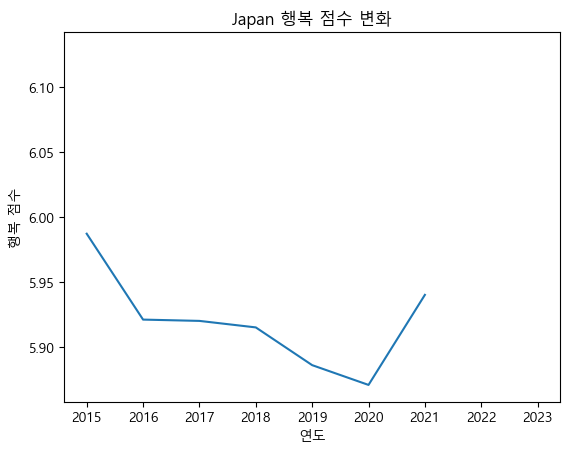

In [10]:
import matplotlib.pyplot as plt

#한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 특정 나라의 행복 점수 및 순위 시각화
country = "Japan"
country_data = allgps[allgps['Country'] == country]

# 그래프 생성
ax = country_data.plot(
    x='Year',
    y='Happiness Score',
    kind='line',
    title=f'{country} 행복 점수 변화',
    legend=False
)

# 한국어로 축 레이블 설정
ax.set_xlabel('연도')  # x축 레이블
ax.set_ylabel('행복 점수')  # y축 레이블

# 그래프 표시
plt.show()


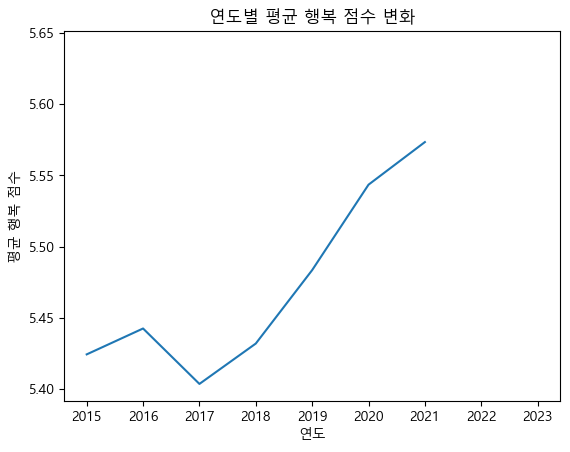

In [11]:
import matplotlib.pyplot as plt

# 윈도우에서 한글 폰트 설정 (맑은 고딕)
plt.rc('font', family='Malgun Gothic')

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 연도별 평균 행복 점수 시각화
yearly_avg = allgps.groupby('Year')['Happiness Score'].mean()

# 그래프 생성
ax = yearly_avg.plot(kind='line', title='연도별 평균 행복 점수 변화')

# 축 레이블을 한국어로 설정
plt.xlabel('연도')  # x축 레이블
plt.ylabel('평균 행복 점수')  # y축 레이블

# 그래프 표시
plt.show()


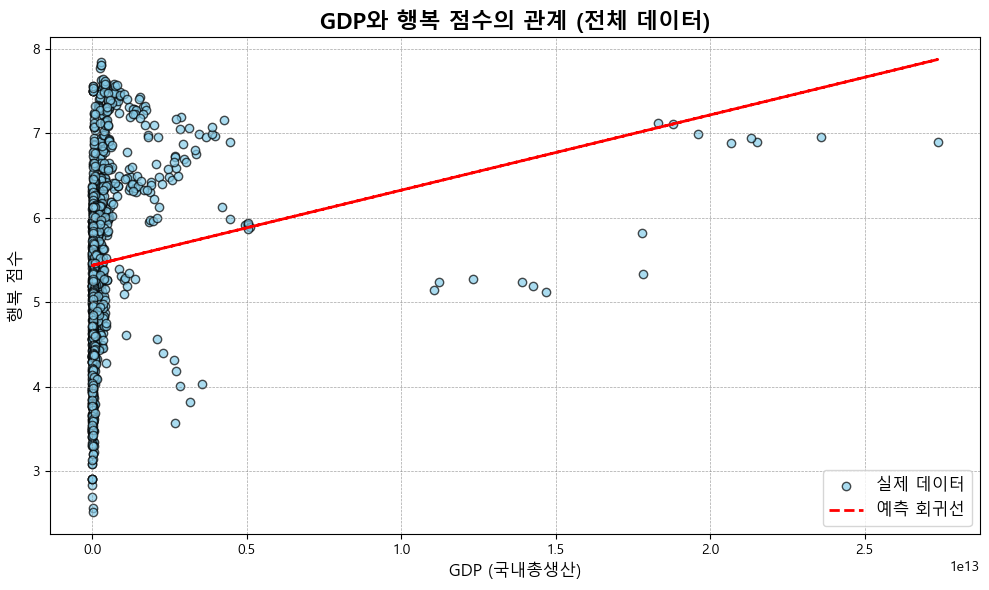

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 결측치 제거 (GDP와 Happiness Score)
allgps_cleaned = allgps.dropna(subset=['GDP', 'Happiness Score'])

# X와 Y 정의 (전체 데이터 사용)
X = allgps_cleaned['GDP']
Y = allgps_cleaned['Happiness Score']

# 산점도 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.scatter(X, Y, color='skyblue', alpha=0.7, edgecolor='k', label='실제 데이터')

# 회귀선 계산
m, b = np.polyfit(X, Y, 1)  # 선형 회귀 (기울기 m, 절편 b)
plt.plot(X, m*X + b, color='red', linewidth=2, linestyle='--', label='예측 회귀선')

# 그래프 제목과 축 레이블
plt.title('GDP와 행복 점수의 관계 (전체 데이터)', fontsize=16, fontweight='bold')
plt.xlabel('GDP (국내총생산)', fontsize=12)
plt.ylabel('행복 점수', fontsize=12)

# 축 레이블 크기 조정
plt.tick_params(axis='both', which='major', labelsize=10)

# 범례 추가
plt.legend(fontsize=12)

# 격자 추가
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()


In [16]:
import folium

# 2023년도 데이터 필터링 (결측치 제거)
data_2023 = allgps[allgps['Year'] == 2023].dropna(subset=['Latitude', 'Longitude', 'Happiness Rank', 'Country Code_y'])

# Folium 지도 생성
world_map = folium.Map(location=[20, 0], zoom_start=2)

# 국가별 국기 URL 형식
flag_base_url = "https://hatscripts.github.io/circle-flags/flags/{country_code}.svg"

# 나라별 핀 추가
for _, row in data_2023.iterrows():
    rank = row['Happiness Rank']
    country = row['Country']
    lat = row['Latitude']
    lon = row['Longitude']
    country_code = row['Country Code_y'].lower()  # ISO 국가 코드 (소문자)

    # 국기 URL 생성
    flag_url = flag_base_url.format(country_code=country_code)

    # Custom Icon (국기)
    icon = folium.CustomIcon(
        flag_url,
        icon_size=(30, 30)  # 아이콘 크기 조정
    )

    # 핀 추가
    folium.Marker(
        location=[lat, lon],
        popup=f"{country} (행복 순위: {int(rank)})",
        tooltip=f"{country} 순위: {int(rank)}",
        icon=icon
    ).add_to(world_map)

# 지도 표시
world_map
